<a href="https://colab.research.google.com/github/atick-faisal/Hand-Gesture-Recognition/blob/main/Deep-Learning-Analysis/Dynamic_Hand_Gestures_DL_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [32]:
import os
import time
import joblib
import shutil
import tarfile
import requests

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import butter, lfilter

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

%matplotlib inline
sns.set(font_scale=1.5)
sns.set_style("darkgrid", {'font.family': 'serif',
              'font.serif': 'Times New Roman'})

In [3]:

DATASET_ID      = '1p0CSRb9gax0sKqdyzOYVt-BXvZ4GtrBv'

# -------------BASE DIR (MODIFY THIS TO YOUR NEED) ------------ #
BASE_DIR        = '.'
# BASE_DIR     = '/content/drive/MyDrive/Research/Hand Gesture/GitHub/'

DATA_DIR        = 'Sensor-Data/'
CHANNELS_DIR    = 'Channels/'
FEATURES_DIR    = 'Features/'
FIGURE_DIR      = 'Figures/'
LOG_DIR         = 'Logs/'

USERS           = ['001', '002', '003', '004', '005', '006', '007', '008', '009',
                   '010', '011', '012', '013', '014', '015', '016', '017', '018',
                   '019', '020', '021', '022', '023', '024', '025']
GESTURES        = ['j', 'z', 'bad', 'deaf', 'fine', 'good', 'goodbye', 'hello', 'hungry',
                   'me', 'no', 'please', 'sorry', 'thankyou', 'yes', 'you']

WINDOW_LEN      = 150

# ------------- FOR THE GREATER GOOD :) ------------- #
DATASET_LEN     = 1120
TRAIN_LEN       = 960
TEST_LEN        = 160

TEST_USER       = '001'
EPOCHS          = 5

CHANNELS_GROUP  = 'DYNAMIC_ACC_ONLY_'
CUT_OFF         = 3.0
ORDER           = 4
FS              = 100

CONFIG          = "Rolling median filter for flex, LPF for IMU, Stacked CNN, epochs 20, lr 0.001\n"

In [4]:

#--------------------- Download util for Google Drive ------------------- #

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
        
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
        
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:
                f.write(chunk)

def download_data(fid, destination):
    print('cleaning already existing files ... ', end='')
    try:
        shutil.rmtree(destination)
        print('√')
    except:
        print('✕')
        
    print('creating data directory ... ', end='')
    os.mkdir(destination)
    print('√')
    
    print('downloading dataset from the repository ... ', end='')
    filename = os.path.join(destination, 'dataset.tar.xz')
    try:
        download_file_from_google_drive(fid, filename)
        print('√')
    except:
        print('✕')
        
    print('extracting the dataset ... ', end='')
    try:
        tar = tarfile.open(filename)
        tar.extractall(destination)
        tar.close()
        print('√')
    except:
        print('✕')

In [5]:

# ------- Comment This if already downloaded -------- #

destination = os.path.join(BASE_DIR, DATA_DIR)
download_data(DATASET_ID, destination)

cleaning already existing files ... √
creating data directory ... √
downloading dataset from the repository ... √
extracting the dataset ... √


In [6]:
class LowPassFilter(object): 
    def butter_lowpass(cutoff, fs, order):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def apply(data, cutoff=CUT_OFF, fs=FS, order=ORDER):
        b, a = LowPassFilter.butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data)
        return y

In [7]:
def clean_dir(path):
    print('cleaning already existing files ... ', end='')
    try:
        shutil.rmtree(path)
        print('√')
    except:
        print('✕')
    
    print('creating ' + path + ' directory ... ', end='')
    os.mkdir(path)
    print('√')

def extract_channels():
    channels_dir = os.path.join(BASE_DIR, CHANNELS_DIR)
    clean_dir(channels_dir)
        
    for user in USERS:
        print('Processing data for user ' + user, end=' ')
        
        X = []
        y = []
        first_time = True
        
        for gesture in GESTURES:
              
            user_dir = os.path.join(BASE_DIR, DATA_DIR, user)
            gesture_dir = os.path.join(user_dir, gesture + '.csv')

            dataset = pd.read_csv(gesture_dir)

            dataset['flex_1'] = dataset['flex_1'].rolling(3).median()
            dataset['flex_2'] = dataset['flex_2'].rolling(3).median()
            dataset['flex_3'] = dataset['flex_3'].rolling(3).median()
            dataset['flex_4'] = dataset['flex_4'].rolling(3).median()
            dataset['flex_5'] = dataset['flex_5'].rolling(3).median()

            dataset.fillna(0, inplace=True)

            # flex = ['flex_1', 'flex_2', 'flex_3', 'flex_4', 'flex_5']
            # max_flex = dataset[flex].max(axis=1)
            # max_flex.replace(0, 1, inplace=True)
            # dataset[flex] = dataset[flex].divide(max_flex, axis=0)
            
            flx1 = dataset['flex_1'].to_numpy().reshape(-1, WINDOW_LEN)
            flx2 = dataset['flex_2'].to_numpy().reshape(-1, WINDOW_LEN)
            flx3 = dataset['flex_3'].to_numpy().reshape(-1, WINDOW_LEN)
            flx4 = dataset['flex_4'].to_numpy().reshape(-1, WINDOW_LEN)
            flx5 = dataset['flex_5'].to_numpy().reshape(-1, WINDOW_LEN)
            
            accx = dataset['ACCx'].to_numpy()
            accy = dataset['ACCy'].to_numpy()
            accz = dataset['ACCz'].to_numpy()
            
            accx = LowPassFilter.apply(accx).reshape(-1, WINDOW_LEN)
            accy = LowPassFilter.apply(accy).reshape(-1, WINDOW_LEN)
            accz = LowPassFilter.apply(accz).reshape(-1, WINDOW_LEN)
            
            gyrx = dataset['GYRx'].to_numpy()
            gyry = dataset['GYRy'].to_numpy()
            gyrz = dataset['GYRz'].to_numpy()
            
            gyrx = LowPassFilter.apply(gyrx).reshape(-1, WINDOW_LEN)
            gyry = LowPassFilter.apply(gyry).reshape(-1, WINDOW_LEN)
            gyrz = LowPassFilter.apply(gyrz).reshape(-1, WINDOW_LEN)
            
            accm = np.sqrt(accx ** 2 + accy ** 2 + accz ** 2)
            gyrm = np.sqrt(gyrx ** 2 + gyry ** 2 + gyrz ** 2)
            
            g_idx = GESTURES.index(gesture)
            labels = np.ones((accx.shape[0], 1)) * g_idx
            
            channels = np.stack([
                flx1, flx2, flx3, flx4, flx5,
                accx, accy, accz
            ], axis=-1)
            
            if first_time == True:
                X = channels
                y = labels
                first_time = False
            else:
                X = np.append(X, channels, axis=0)
                y = np.append(y, labels, axis=0)
            
        
        x_path = os.path.join(BASE_DIR, CHANNELS_DIR, CHANNELS_GROUP + user + '_X.joblib')
        y_path = os.path.join(BASE_DIR, CHANNELS_DIR, CHANNELS_GROUP + user + '_y.joblib')
        joblib.dump(X, x_path)
        joblib.dump(y, y_path)
        
        print('√')
        

In [8]:
extract_channels()

cleaning already existing files ... √
creating ./Channels/ directory ... √
Processing data for user 001 √
Processing data for user 002 √
Processing data for user 003 √
Processing data for user 004 √
Processing data for user 005 √
Processing data for user 006 √
Processing data for user 007 √
Processing data for user 008 √
Processing data for user 009 √
Processing data for user 010 √
Processing data for user 011 √
Processing data for user 012 √
Processing data for user 013 √
Processing data for user 014 √
Processing data for user 015 √
Processing data for user 016 √
Processing data for user 017 √
Processing data for user 018 √
Processing data for user 019 √
Processing data for user 020 √
Processing data for user 021 √
Processing data for user 022 √
Processing data for user 023 √
Processing data for user 024 √
Processing data for user 025 √


In [9]:
def get_model(input_shape = (150, 8)):

    optimizer = tf.keras.optimizers.Adam(0.0001)

    model = Sequential()
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(GESTURES), activation='softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    return model

In [10]:
def get_conv_block():
    input = Input(shape=(150, 1))
    x = BatchNormalization()(input)
    x = Conv1D(filters=8, kernel_size=3, activation='selu', padding='valid')(x)
    x = Conv1D(filters=16, kernel_size=3, activation='selu', padding='valid')(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(filters=16, kernel_size=3, activation='selu', padding='valid')(x)
    x = Conv1D(filters=16, kernel_size=3, activation='selu', padding='valid')(x)
    x = MaxPooling1D(2)(x)
    x = Flatten()(x)
    x = Dense(50, activation='elu')(x)

    return input, x

def get_stacked_model(n=8):
    inputs = []
    CNNs = []

    for i in range(n):
        input_i, CNN_i = get_conv_block()
        inputs.append(input_i)
        CNNs.append(CNN_i)

    x = concatenate(CNNs, axis=-1)
    x = Dropout(0.5)(x)
    x = Dense(100, activation='selu')(x)
    x = Dropout(0.5)(x)
    # x = Dense(20, activation='selu')(x)
    # x = Dropout(0.5)(x)
    output = Dense(len(GESTURES), activation='softmax')(x)
    model = Model(inputs, output)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [11]:

ACC = []
logs = ''

for test_user in ['001']:
    print('Processing results for user ' + test_user, end='... \n')
    
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    
    first_time_train = True
    first_time_test = True

    for user in USERS:
        x_path = os.path.join(BASE_DIR, CHANNELS_DIR, CHANNELS_GROUP + user + '_X.joblib')
        y_path = os.path.join(BASE_DIR, CHANNELS_DIR, CHANNELS_GROUP + user + '_y.joblib')
        X = joblib.load(x_path)
        y = joblib.load(y_path)

        if user == test_user:
            if first_time_train == True:
                first_time_train = False
                X_test = X
                y_test = y
                
            else:
                X_test = np.append(X_test, X, axis=0)
                y_test = np.append(y_test, y, axis=0)
                
        else:
            if first_time_test == True:
                first_time_test = False
                X_train = X
                y_train = y
                
            else:
                X_train = np.append(X_train, X, axis=0)
                y_train = np.append(y_train, y, axis=0)


    X_train, y_train = shuffle(X_train, y_train)
    
    # y_train = to_categorical(y_train)
    # y_test = to_categorical(y_test)

    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30, 
        mode='min',
        restore_best_weights=True,
    ) 

    model = get_stacked_model()
    model.fit(
        np.split(X_train, 8, axis=-1), 
        y_train, 
        epochs=300, 
        validation_data=(np.split(X_test, 8, axis=-1), y_test),
        batch_size=32, 
        callbacks=[callback]
    )

    y_pred = model.predict(np.split(X_test, 8, axis=-1))
    _, accuracy = model.evaluate(np.split(X_test, 8, axis=-1), y_test, batch_size=32)

    accuracy = accuracy * 100
    print(f'%.2f %%' %(accuracy))
    logs = logs + 'Accuracy for user ' + str(test_user) + '... ' + str(accuracy) + '\n'
    ACC.append(accuracy)
    
AVG_ACC = np.mean(ACC)
STD = np.std(ACC)
print('------------------------------------')
print(f'Average accuracy %.2f +/- %.2f' %(AVG_ACC, STD))

Processing results for user 001... 
Epoch 1/300
120/120 [==============================] - 10s 36ms/step - loss: 2.6131 - accuracy: 0.2734 - val_loss: 1.0768 - val_accuracy: 0.6625
Epoch 2/300
120/120 [==============================] - 3s 28ms/step - loss: 1.3279 - accuracy: 0.5589 - val_loss: 0.6401 - val_accuracy: 0.8188
Epoch 3/300
120/120 [==============================] - 3s 28ms/step - loss: 1.0064 - accuracy: 0.6576 - val_loss: 0.5079 - val_accuracy: 0.8000
Epoch 4/300
120/120 [==============================] - 3s 28ms/step - loss: 0.8144 - accuracy: 0.7281 - val_loss: 0.4313 - val_accuracy: 0.8375
Epoch 5/300
120/120 [==============================] - 3s 28ms/step - loss: 0.7126 - accuracy: 0.7716 - val_loss: 0.3792 - val_accuracy: 0.8562
Epoch 6/300
120/120 [==============================] - 3s 28ms/step - loss: 0.5927 - accuracy: 0.8068 - val_loss: 0.3050 - val_accuracy: 0.9062
Epoch 7/300
120/120 [==============================] - 3s 28ms/step - loss: 0.5387 - accuracy: 0.81

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00        10
         2.0       1.00      1.00      1.00        10
         3.0       1.00      1.00      1.00        10
         4.0       1.00      1.00      1.00        10
         5.0       1.00      0.90      0.95        10
         6.0       1.00      1.00      1.00        10
         7.0       1.00      1.00      1.00        10
         8.0       1.00      1.00      1.00        10
         9.0       1.00      1.00      1.00        10
        10.0       1.00      1.00      1.00        10
        11.0       1.00      1.00      1.00        10
        12.0       1.00      1.00      1.00        10
        13.0       0.91      1.00      0.95        10
        14.0       1.00      1.00      1.00        10
        15.0       1.00      1.00      1.00        10

    accuracy                           0.99       160
   macro avg       0.99   

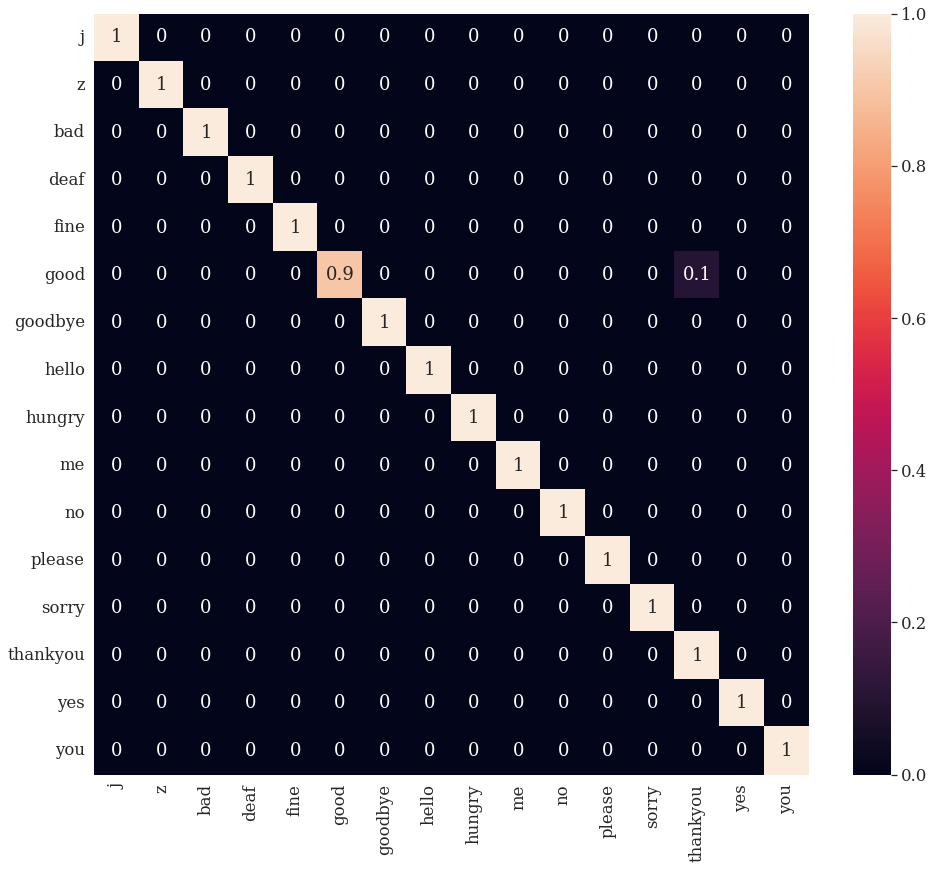

In [40]:
print(classification_report(y_test.ravel(), np.argmax(y_pred, axis=1)))
cm = confusion_matrix(y_test.ravel(), np.argmax(y_pred, axis=1), normalize='true')
cm_df = pd.DataFrame(cm, columns=GESTURES, index=GESTURES)

plt.figure(figsize=(16, 14))
sns.heatmap(cm_df, annot=True)
plt.show()

In [ ]:
line = '---------------------------------------\n'
log_dir = os.path.join(BASE_DIR, LOG_DIR)
if not os.path.exists(log_dir):
    os.mkdir(log_dir)
f = open(os.path.join(log_dir, 'logs_dl_basic_cnn.txt'), 'a')
f.write(CONFIG)
f.write(logs)
f.write(line)
f.write(f'Average accuracy %.2f +/- %.2f' %(AVG_ACC, STD))
f.write('\n\n')
f.close()